In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

%matplotlib inline


In [28]:
# 1. Definição de Caminhos
caminho_csv_principal = os.path.join('..', 'data', 'raw', 'exams.csv')
pasta_dados_brutos = os.path.join('..', 'data', 'raw')
pasta_saida_classificada = os.path.join('..', 'data','processed', 'classified_ecgs_code15')

# 2. Hierarquia de Classificação ATUALIZADA (sem 'RUIDO')
HIERARQUIA_DIAGNOSTICOS = {
    'AF': ['AF'],
    'NORMAL': ['normal_ecg'],
    'OTHER': ['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST']
}

# 3. Cria a nova estrutura de pastas de saída (apenas as 3 pastas desejadas)
print("--- CRIANDO ESTRUTURA DE PASTAS DE SAÍDA (SEM RUIDO) ---")
for categoria in HIERARQUIA_DIAGNOSTICOS:
    caminho_categoria = os.path.join(pasta_saida_classificada, categoria)
    os.makedirs(caminho_categoria, exist_ok=True)
    print(f"Pasta '{caminho_categoria}' pronta.")

--- CRIANDO ESTRUTURA DE PASTAS DE SAÍDA (SEM RUIDO) ---
Pasta '..\data\processed\classified_ecgs_code15\AF' pronta.
Pasta '..\data\processed\classified_ecgs_code15\NORMAL' pronta.
Pasta '..\data\processed\classified_ecgs_code15\OTHER' pronta.


In [ ]:
print("\n--- INICIANDO PIPELINE (IGNORANDO EXAMES NÃO CLASSIFICADOS) ---")

contadores = {categoria: 0 for categoria in HIERARQUIA_DIAGNOSTICOS}
ignorados_count = 0

try:
    print(f"\nCarregando o arquivo 'mapa' de rótulos de: {caminho_csv_principal}")
    df_mapa_global = pd.read_csv(caminho_csv_principal)
    print("Arquivo 'mapa' carregado com sucesso.")

    for i in range(9):
        nome_arquivo_hdf5 = f'exams_part{i}.hdf5'
        caminho_entrada_hdf5 = os.path.join(pasta_dados_brutos, nome_arquivo_hdf5)
        
        if not os.path.exists(caminho_entrada_hdf5):
            continue
            
        print(f"\nProcessando Lote {i}: {nome_arquivo_hdf5}...")

        rotulos_do_lote = df_mapa_global[df_mapa_global['trace_file'] == nome_arquivo_hdf5].copy()
        ids_necessarios = rotulos_do_lote['exam_id'].tolist()
        
        if not ids_necessarios:
            continue

        with h5py.File(caminho_entrada_hdf5, 'r') as f:
            ids_no_hdf5 = f['exam_id'][:]
            sinais_no_hdf5 = f['tracings'][:]
        
        mapa_id_para_posicao = {id_val: pos for pos, id_val in enumerate(ids_no_hdf5)}
        
        for index, linha_rotulo in rotulos_do_lote.iterrows():
            exam_id = linha_rotulo['exam_id']
            
            posicao = mapa_id_para_posicao.get(exam_id)
            if posicao is None:
                continue
            
            sinal_d1_individual = sinais_no_hdf5[posicao, :, 0]

            # --- LÓGICA DE CLASSIFICAÇÃO ATUALIZADA ---
            pasta_alvo = None
            if linha_rotulo['AF']:
                pasta_alvo = 'AF'
            elif linha_rotulo['normal_ecg']:
                pasta_alvo = 'NORMAL'
            elif linha_rotulo[HIERARQUIA_DIAGNOSTICOS['OTHER']].any():
                pasta_alvo = 'OTHER'
            else:
                ignorados_count += 1
                continue 

            nome_arquivo_saida = f"{exam_id}.npy"
            caminho_final = os.path.join(pasta_saida_classificada, pasta_alvo, nome_arquivo_saida)
            
            if not os.path.exists(caminho_final):
                np.save(caminho_final, sinal_d1_individual)
            
            contadores[pasta_alvo] += 1
            
        print(f"  -> Lote {i} processado.")

except Exception as e:
    print(f"\n!!! ERRO CRÍTICO DURANTE O PIPELINE: {e}")

print("\n--- PIPELINE CONCLUÍDO ---")


--- INICIANDO PIPELINE (IGNORANDO EXAMES NÃO CLASSIFICADOS) ---

Carregando o arquivo 'mapa' de rótulos de: ..\data\raw\exams.csv
Arquivo 'mapa' carregado com sucesso.

Processando Lote 0: exams_part0.hdf5...
  -> Lote 0 processado.

Processando Lote 1: exams_part1.hdf5...
  -> Lote 1 processado.

Processando Lote 2: exams_part2.hdf5...
  -> Lote 2 processado.

Processando Lote 3: exams_part3.hdf5...
  -> Lote 3 processado.

Processando Lote 4: exams_part4.hdf5...
  -> Lote 4 processado.

Processando Lote 5: exams_part5.hdf5...
  -> Lote 5 processado.

Processando Lote 6: exams_part6.hdf5...
  -> Lote 6 processado.

Processando Lote 7: exams_part7.hdf5...
  -> Lote 7 processado.

Processando Lote 8: exams_part8.hdf5...
  -> Lote 8 processado.

--- PIPELINE CONCLUÍDO ---


In [30]:
print("\n--- RELATÓRIO FINAL DE CLASSIFICAÇÃO ---")

total_reorganizado = sum(contadores.values())
print(f"Total de Exames Salvos: {total_reorganizado}")

for categoria, contagem in contadores.items():
    porcentagem = (contagem / total_reorganizado * 100) if total_reorganizado > 0 else 0
    print(f"- Pasta '{categoria}': {contagem} exames ({porcentagem:.2f}%)")
    
print("-" * 40)
print(f"Total de Exames Ignorados (não classificados): {ignorados_count}")


--- RELATÓRIO FINAL DE CLASSIFICAÇÃO ---
Total de Exames Salvos: 88150
- Pasta 'AF': 3624 exames (4.11%)
- Pasta 'NORMAL': 68468 exames (77.67%)
- Pasta 'OTHER': 16058 exames (18.22%)
----------------------------------------
Total de Exames Ignorados (não classificados): 91850


### Celula para visualizaçãos de dados processados

In [34]:

# 1. Definição de Caminhos e Categorias
pasta_saida_classificada = os.path.join('..', 'data', 'processed', 'classified_ecgs_code15')
categorias = ['AF', 'NORMAL', 'OTHER'] 
num_exemplos_por_categoria = 2

arquivos_por_categoria = {}

print("--- COLETANDO ARQUIVOS PARA VISUALIZAÇÃO (SEM RUIDO) ---")
for categoria in categorias:
    caminho_categoria = os.path.join(pasta_saida_classificada, categoria)
    if os.path.exists(caminho_categoria):
        lista_de_arquivos = [os.path.join(caminho_categoria, f) for f in os.listdir(caminho_categoria) if f.endswith('.npy')]
        arquivos_por_categoria[categoria] = lista_de_arquivos
        print(f"- Categoria '{categoria}': {len(lista_de_arquivos)} arquivos encontrados.")
    else:
        arquivos_por_categoria[categoria] = []
        print(f"- Categoria '{categoria}': Pasta não encontrada.")

--- COLETANDO ARQUIVOS PARA VISUALIZAÇÃO (SEM RUIDO) ---
- Categoria 'AF': 3624 arquivos encontrados.
- Categoria 'NORMAL': 68468 arquivos encontrados.
- Categoria 'OTHER': 16058 arquivos encontrados.


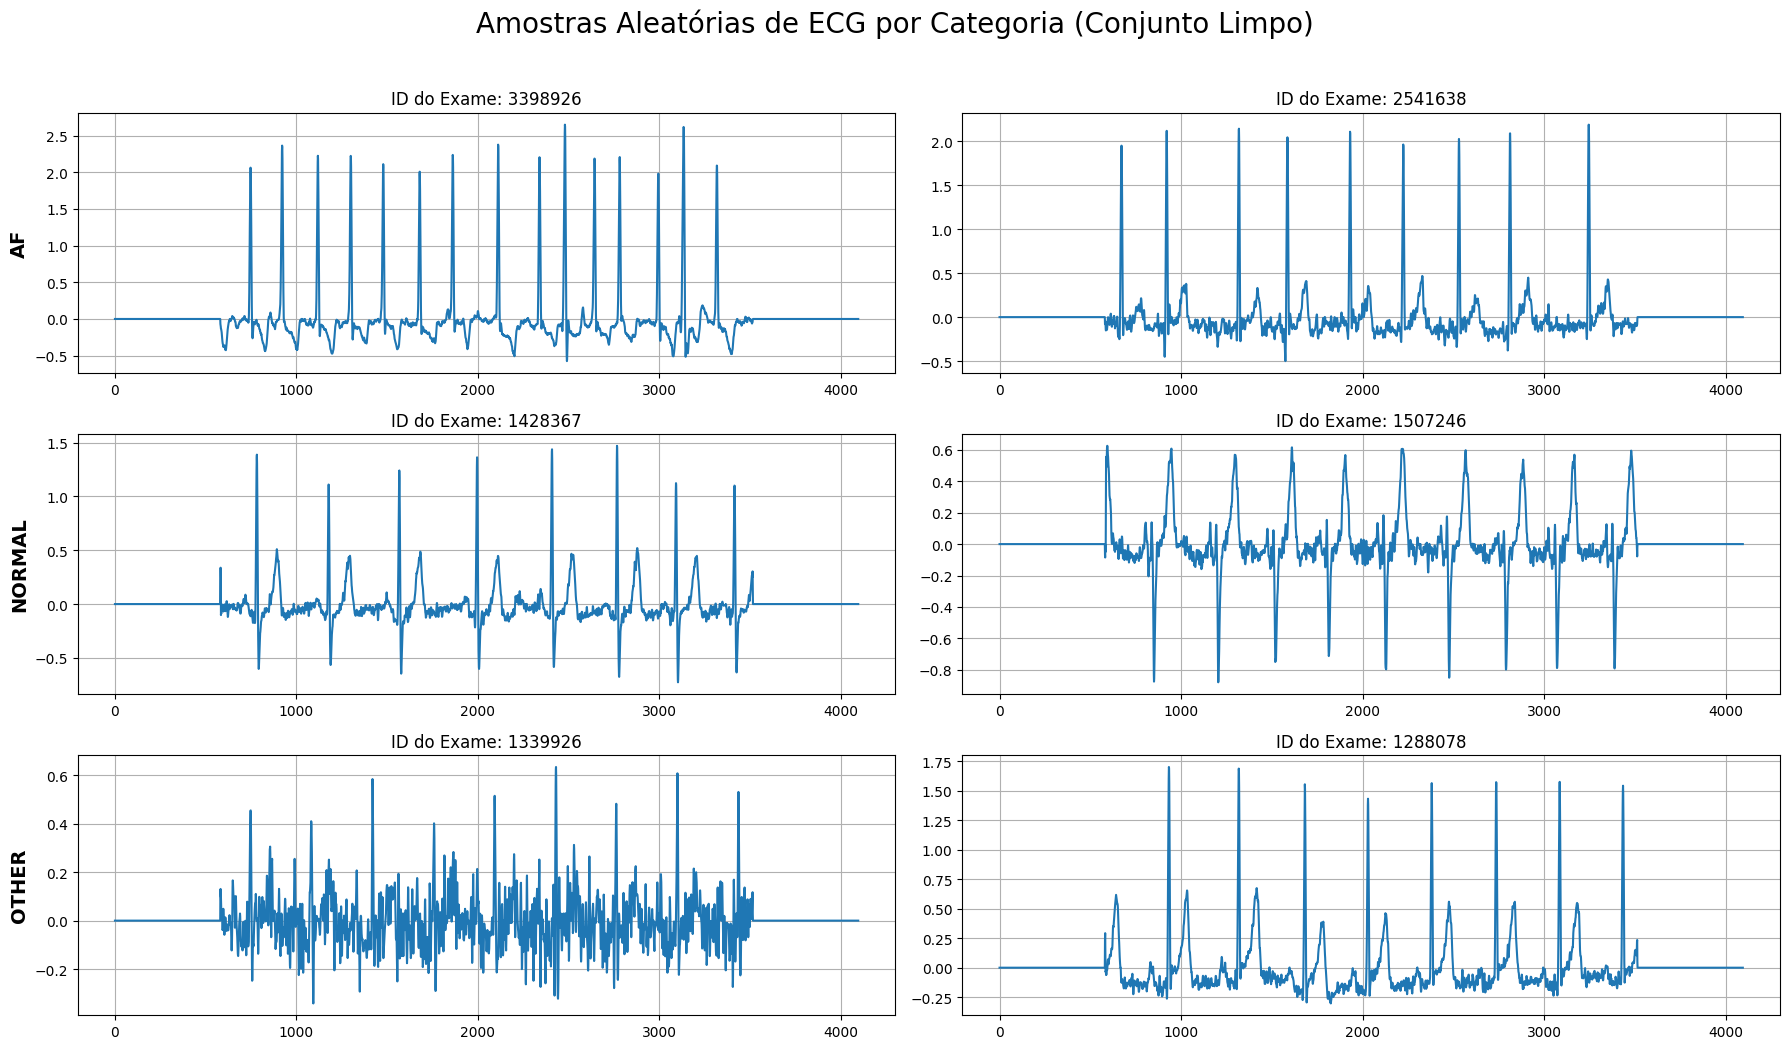

In [35]:
# --- CÉLULA DE VISUALIZAÇÃO (SEM RUIDO) ---

fig, axes = plt.subplots(len(categorias), num_exemplos_por_categoria, figsize=(18, 11))
fig.suptitle("Amostras Aleatórias de ECG por Categoria (Conjunto Limpo)", fontsize=20)

for i, categoria in enumerate(categorias):
    
    lista_de_arquivos = arquivos_por_categoria.get(categoria, [])
    
    arquivos_selecionados = random.sample(lista_de_arquivos, min(len(lista_de_arquivos), num_exemplos_por_categoria))

    for j in range(num_exemplos_por_categoria):
        ax = axes[i, j]
        
        if j == 0:
            ax.set_ylabel(categoria, fontsize=14, weight='bold')

        if j < len(arquivos_selecionados):
            caminho_arquivo = arquivos_selecionados[j]
            sinal_ecg = np.load(caminho_arquivo)
            
            ax.plot(sinal_ecg)
            ax.grid(True)
            
            exam_id = os.path.splitext(os.path.basename(caminho_arquivo))[0]
            ax.set_title(f"ID do Exame: {exam_id}")
        else:
            ax.axis('off')
            ax.set_title(f"(Amostra não disponível)")

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### Parte 2 Extraçao dos exames 9 ao 17

In [ ]:
# 1. Definição de Caminhos
caminho_csv_principal = os.path.join('..', 'data', 'raw', 'exams.csv')
pasta_dados_brutos = os.path.join('..', 'data', 'raw')

pasta_saida_classificada = os.path.join('..', 'data', 'processed', 'classified_ecgs_code15')

HIERARQUIA_DIAGNOSTICOS = {
    'AF': ['AF'],
    'NORMAL': ['normal_ecg'],
    'OTHER': ['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST']
}

# 3. Cria a nova estrutura de pastas de saída
print("--- CRIANDO ESTRUTURA DE PASTAS DE SAÍDA ATUALIZADA ---")
for categoria in HIERARQUIA_DIAGNOSTICOS:
    caminho_categoria = os.path.join(pasta_saida_classificada, categoria)
    os.makedirs(caminho_categoria, exist_ok=True)
    print(f"Pasta '{caminho_categoria}' pronta.")

--- CRIANDO ESTRUTURA DE PASTAS DE SAÍDA ATUALIZADA ---
Pasta '..\data\processed\classified_ecgs_code15\AF' pronta.
Pasta '..\data\processed\classified_ecgs_code15\NORMAL' pronta.
Pasta '..\data\processed\classified_ecgs_code15\OTHER' pronta.


In [37]:
print("\n--- INICIANDO PIPELINE (LOTE DE ARQUIVOS 9 A 17) ---")

# Contadores para o relatório deste lote
contadores = {categoria: 0 for categoria in HIERARQUIA_DIAGNOSTICOS}
ignorados_count = 0

try:
    print(f"\nCarregando o arquivo 'mapa' de rótulos de: {caminho_csv_principal}")
    df_mapa_global = pd.read_csv(caminho_csv_principal)
    print("Arquivo 'mapa' carregado com sucesso.")

    # !!! MUDANÇA AQUI: Novo intervalo de arquivos !!!
    # range(9, 18) irá processar os números 9, 10, 11, 12, 13, 14, 15, 16, 17.
    for i in range(9, 18):
        nome_arquivo_hdf5 = f'exams_part{i}.hdf5'
        caminho_entrada_hdf5 = os.path.join(pasta_dados_brutos, nome_arquivo_hdf5)
        
        if not os.path.exists(caminho_entrada_hdf5):
            print(f"\nAVISO: Arquivo {nome_arquivo_hdf5} não encontrado. Pulando lote {i}.")
            continue
            
        print(f"\nProcessando Lote {i}: {nome_arquivo_hdf5}...")

        rotulos_do_lote = df_mapa_global[df_mapa_global['trace_file'] == nome_arquivo_hdf5].copy()
        ids_necessarios = rotulos_do_lote['exam_id'].tolist()
        
        if not ids_necessarios:
            print("  -> Nenhum exame encontrado no CSV para este arquivo. Pulando.")
            continue

        with h5py.File(caminho_entrada_hdf5, 'r') as f:
            ids_no_hdf5 = f['exam_id'][:]
            sinais_no_hdf5 = f['tracings'][:]
        
        mapa_id_para_posicao = {id_val: pos for pos, id_val in enumerate(ids_no_hdf5)}
        
        for index, linha_rotulo in rotulos_do_lote.iterrows():
            exam_id = linha_rotulo['exam_id']
            
            posicao = mapa_id_para_posicao.get(exam_id)
            if posicao is None:
                continue
            
            sinal_d1_individual = sinais_no_hdf5[posicao, :, 0]

            pasta_alvo = None
            if linha_rotulo['AF']:
                pasta_alvo = 'AF'
            elif linha_rotulo['normal_ecg']:
                pasta_alvo = 'NORMAL'
            elif linha_rotulo[HIERARQUIA_DIAGNOSTICOS['OTHER']].any():
                pasta_alvo = 'OTHER'
            else:
                ignorados_count += 1
                continue

            nome_arquivo_saida = f"{exam_id}.npy"
            caminho_final = os.path.join(pasta_saida_classificada, pasta_alvo, nome_arquivo_saida)
            
            if not os.path.exists(caminho_final):
                np.save(caminho_final, sinal_d1_individual)
            
            contadores[pasta_alvo] += 1
            
        print(f"  -> Lote {i} processado com sucesso.")

except Exception as e:
    print(f"\n!!! ERRO CRÍTICO DURANTE O PIPELINE: {e}")

print("\n--- PIPELINE (LOTE 9-17) CONCLUÍDO ---")


--- INICIANDO PIPELINE (LOTE DE ARQUIVOS 9 A 17) ---

Carregando o arquivo 'mapa' de rótulos de: ..\data\raw\exams.csv
Arquivo 'mapa' carregado com sucesso.

Processando Lote 9: exams_part9.hdf5...
  -> Lote 9 processado com sucesso.

Processando Lote 10: exams_part10.hdf5...
  -> Lote 10 processado com sucesso.

Processando Lote 11: exams_part11.hdf5...
  -> Lote 11 processado com sucesso.

Processando Lote 12: exams_part12.hdf5...
  -> Lote 12 processado com sucesso.

Processando Lote 13: exams_part13.hdf5...
  -> Lote 13 processado com sucesso.

Processando Lote 14: exams_part14.hdf5...
  -> Lote 14 processado com sucesso.

Processando Lote 15: exams_part15.hdf5...
  -> Lote 15 processado com sucesso.

Processando Lote 16: exams_part16.hdf5...
  -> Lote 16 processado com sucesso.

Processando Lote 17: exams_part17.hdf5...
  -> Lote 17 processado com sucesso.

--- PIPELINE (LOTE 9-17) CONCLUÍDO ---


In [38]:
print("\n--- RELATÓRIO DE CLASSIFICAÇÃO (LOTE 9-17) ---")

total_reorganizado = sum(contadores.values())
print(f"Total de Exames Salvos neste lote: {total_reorganizado}")

for categoria, contagem in contadores.items():
    porcentagem = (contagem / total_reorganizado * 100) if total_reorganizado > 0 else 0
    print(f"- Pasta '{categoria}': {contagem} novos exames ({porcentagem:.2f}%)")
    
print("-" * 40)
print(f"Total de Exames Ignorados neste lote: {ignorados_count}")


--- RELATÓRIO DE CLASSIFICAÇÃO (LOTE 9-17) ---
Total de Exames Salvos neste lote: 84282
- Pasta 'AF': 3409 novos exames (4.04%)
- Pasta 'NORMAL': 66189 novos exames (78.53%)
- Pasta 'OTHER': 14684 novos exames (17.42%)
----------------------------------------
Total de Exames Ignorados neste lote: 81497


In [39]:
pasta_dados_classificados = os.path.join('..', 'data', 'processed', 'classified_ecgs_code15')

categorias = ['AF', 'NORMAL', 'OTHER']

contadores_reais = {}

print("--- INICIANDO CONTAGEM REAL DOS ARQUIVOS NAS PASTAS ---")

for categoria in categorias:
    caminho_categoria = os.path.join(pasta_dados_classificados, categoria)
    
    # Verifica se a pasta da categoria realmente existe
    if os.path.exists(caminho_categoria):
        # Cria uma lista de todos os itens na pasta que terminam com '.npy'
        lista_de_arquivos = [f for f in os.listdir(caminho_categoria) if f.endswith('.npy')]
        
        # O número de arquivos é o tamanho dessa lista
        num_arquivos = len(lista_de_arquivos)
        
        # Armazena a contagem
        contadores_reais[categoria] = num_arquivos
        print(f"- Pasta '{categoria}': {num_arquivos} exames encontrados.")
    else:
        # Se a pasta não for encontrada, a contagem é 0
        contadores_reais[categoria] = 0
        print(f"- AVISO: Pasta '{categoria}' não encontrada. Contagem definida como 0.")

total_geral = sum(contadores_reais.values())

print("\n" + "="*40)
print("--- RELATÓRIO GERAL CONSOLIDADO (DADOS REAIS) ---")
print(f"Total de Exames Salvos e Classificados: {total_geral}")
print("-" * 40)
for categoria, contagem in contadores_reais.items():
    porcentagem = (contagem / total_geral * 100) if total_geral > 0 else 0
    print(f"- {categoria}: {contagem} exames ({porcentagem:.2f}%)")
print("="*40)

--- INICIANDO CONTAGEM REAL DOS ARQUIVOS NAS PASTAS ---
- Pasta 'AF': 7033 exames encontrados.
- Pasta 'NORMAL': 134657 exames encontrados.
- Pasta 'OTHER': 30742 exames encontrados.

--- RELATÓRIO GERAL CONSOLIDADO (DADOS REAIS) ---
Total de Exames Salvos e Classificados: 172432
----------------------------------------
- AF: 7033 exames (4.08%)
- NORMAL: 134657 exames (78.09%)
- OTHER: 30742 exames (17.83%)


In [40]:
pasta_dados_classificados = os.path.join('..', 'data', 'processed', 'classified_ecgs_code15')
categorias = ['AF', 'NORMAL', 'OTHER']
num_exemplos_por_categoria = 2

arquivos_por_categoria = {}

print("--- COLETANDO ARQUIVOS PARA VISUALIZAÇÃO ---")
for categoria in categorias:
    caminho_categoria = os.path.join(pasta_dados_classificados, categoria)
    
    if os.path.exists(caminho_categoria):
        # Lista apenas os arquivos .npy e guarda seus caminhos completos
        lista_de_arquivos = [os.path.join(caminho_categoria, f) for f in os.listdir(caminho_categoria) if f.endswith('.npy')]
        arquivos_por_categoria[categoria] = lista_de_arquivos
        print(f"- Categoria '{categoria}': {len(lista_de_arquivos)} arquivos encontrados.")
    else:
        arquivos_por_categoria[categoria] = []
        print(f"- AVISO: Pasta da categoria '{categoria}' não encontrada.")

--- COLETANDO ARQUIVOS PARA VISUALIZAÇÃO ---
- Categoria 'AF': 7033 arquivos encontrados.
- Categoria 'NORMAL': 134657 arquivos encontrados.
- Categoria 'OTHER': 30742 arquivos encontrados.


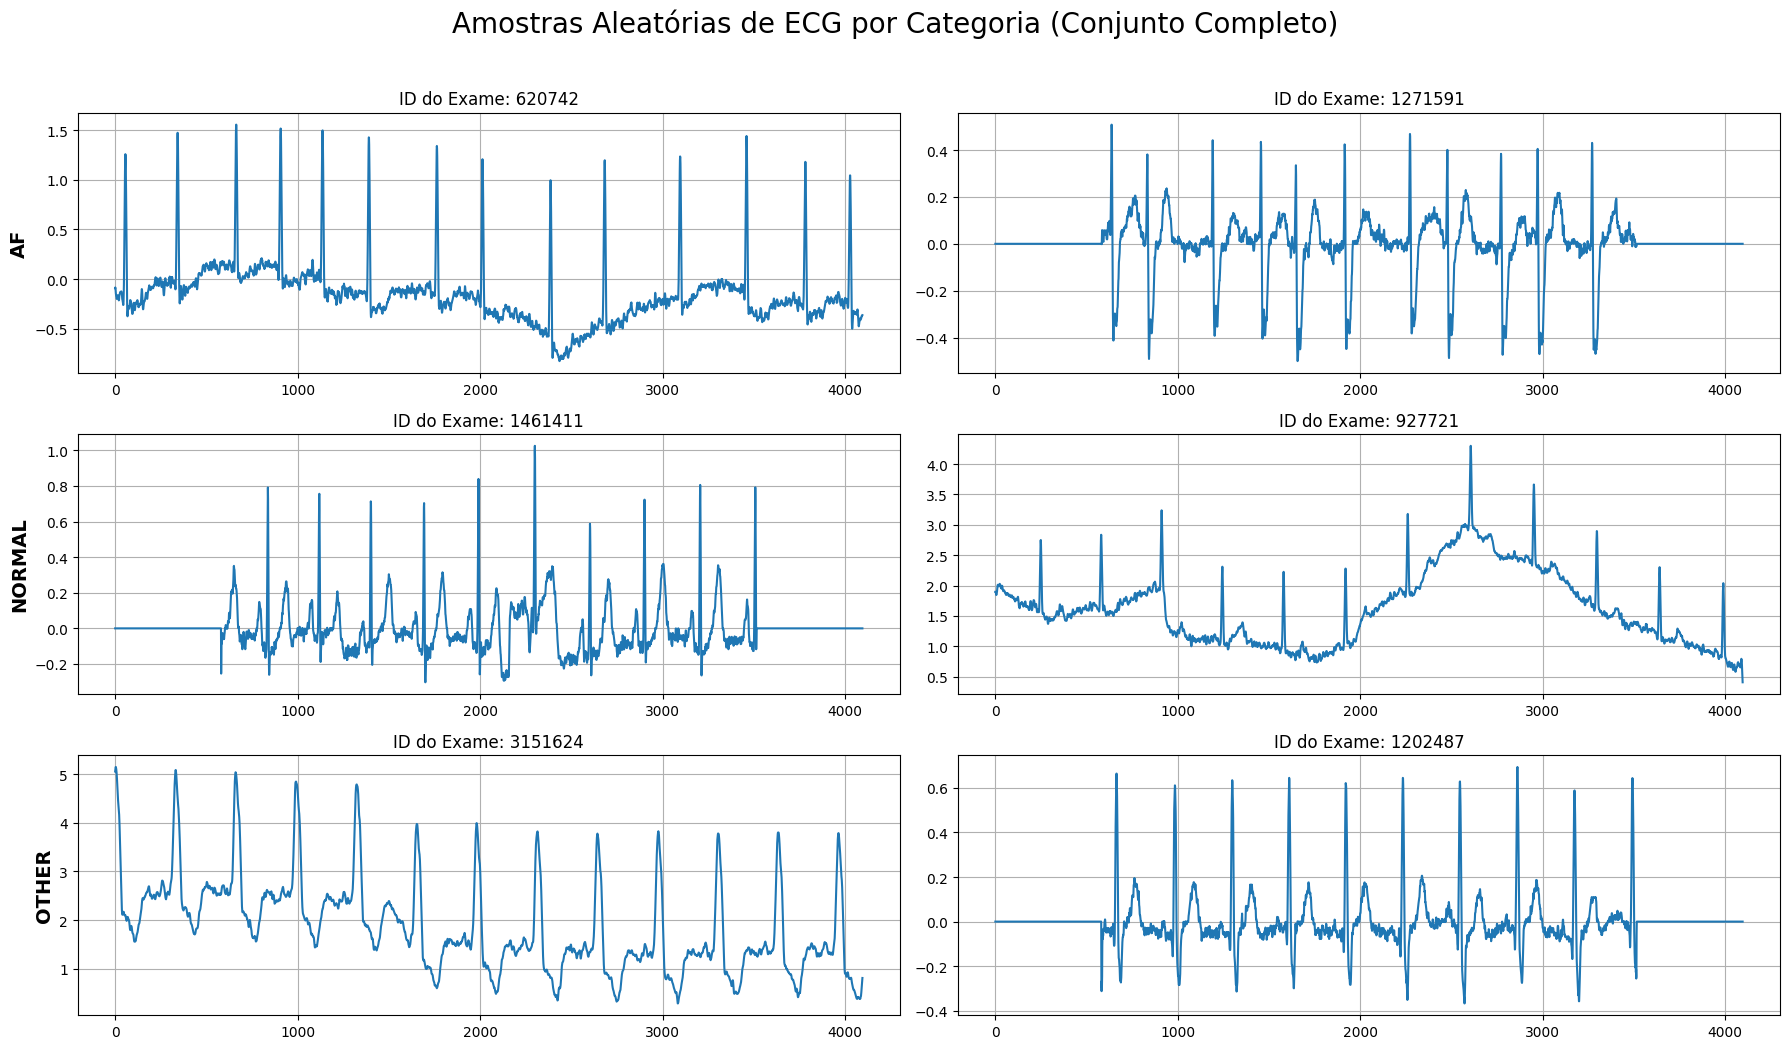

In [41]:
fig, axes = plt.subplots(len(categorias), num_exemplos_por_categoria, figsize=(18, 11))
fig.suptitle("Amostras Aleatórias de ECG por Categoria (Conjunto Completo)", fontsize=20)

for i, categoria in enumerate(categorias):
    
    lista_de_arquivos = arquivos_por_categoria.get(categoria, [])
    
    arquivos_selecionados = random.sample(lista_de_arquivos, min(len(lista_de_arquivos), num_exemplos_por_categoria))
    # Itera para criar os 2 gráficos de exemplo
    for j in range(num_exemplos_por_categoria):
        ax = axes[i, j] # Seleciona o subplot correto na grade (linha i, coluna j)
        
        # Define o título da primeira coluna com o nome da categoria para clareza
        if j == 0:
            ax.set_ylabel(categoria, fontsize=14, weight='bold')

        # Verifica se temos um arquivo para plotar nesta posição
        if j < len(arquivos_selecionados):
            caminho_arquivo = arquivos_selecionados[j]
            
            # Carrega o sinal do ECG do arquivo .npy
            sinal_ecg = np.load(caminho_arquivo)
            
            # Plota o sinal
            ax.plot(sinal_ecg)
            ax.grid(True)
            
            # Extrai o ID do exame do nome do arquivo para usar como título
            exam_id = os.path.splitext(os.path.basename(caminho_arquivo))[0]
            ax.set_title(f"ID do Exame: {exam_id}")
        else:
            # Se não houver amostras suficientes, desliga o eixo
            ax.axis('off')
            ax.set_title(f"(Amostra não disponível)")

# Ajusta o layout para evitar que os títulos e rótulos se sobreponham
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### Dados da Physionet challenge-2011/1.0.0/

In [17]:
import os
import shutil
import wfdb
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# --- 1. Definição dos Caminhos ---
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
processed_data_dir = os.path.join(base_dir, 'data', 'processed')

source_dir_a = os.path.join(raw_data_dir, 'set-a')
destination_dir = os.path.join(processed_data_dir, 'physionet-noise-d1-npy')

# --- 2. Preparação do Diretório de Destino ---
if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)
os.makedirs(destination_dir)

# --- 3. Lógica de Processamento e Salvamento Individual ---
unacceptable_list_file = os.path.join(source_dir_a, 'RECORDS-unacceptable')

try:
    with open(unacceptable_list_file, 'r') as f:
        records_to_process = f.read().splitlines()
    
    print(f"Processando {len(records_to_process)} registros de ruído para conversão individual...")
    
    records_saved = 0
    records_skipped = 0
    
    for record_name in records_to_process:
        record_path = os.path.join(source_dir_a, record_name)
        
        try:
            record_12_lead = wfdb.rdrecord(record_path)
            lead_names = record_12_lead.sig_name
            d1_index = lead_names.index('I')
            signal_d1 = record_12_lead.p_signal[:, d1_index]

            if np.isnan(signal_d1).all():
                print(f"  - Pulando {record_name}: sinal inválido (NaN).")
                records_skipped += 1
                continue

            # Criar o nome do arquivo .npy de saída
            output_npy_filename = f"{record_name}.npy"
            output_npy_path = os.path.join(destination_dir, output_npy_filename)
            
            # Salvar o array do sinal ATUAL como um arquivo .npy individual
            np.save(output_npy_path, signal_d1)
            records_saved += 1

        except Exception as e:
            print(f"  - Falha ao processar {record_name}. Erro: {e}")
            records_skipped += 1
            
    relative_path_for_display = os.path.join(os.path.basename(os.path.dirname(destination_dir)), os.path.basename(destination_dir))
    
    print("\nProcessamento concluído.")
    print(f"Total de {records_saved} arquivos .npy foram criados.")
    print(f"Total de {records_skipped} registros foram pulados.")
    print(f"Arquivos salvos em: .../{relative_path_for_display}/")

except FileNotFoundError:
    print(f"ERRO CRÍTICO: O arquivo de lista 'RECORDS-unacceptable' não foi encontrado.")

Processando 225 registros de ruído para conversão individual...

Processamento concluído.
Total de 225 arquivos .npy foram criados.
Total de 0 registros foram pulados.
Arquivos salvos em: .../processed\physionet-noise-d1-npy/


Arquivo '1138841.npy' carregado com sucesso.
Comprimento do sinal: 5000 pontos.


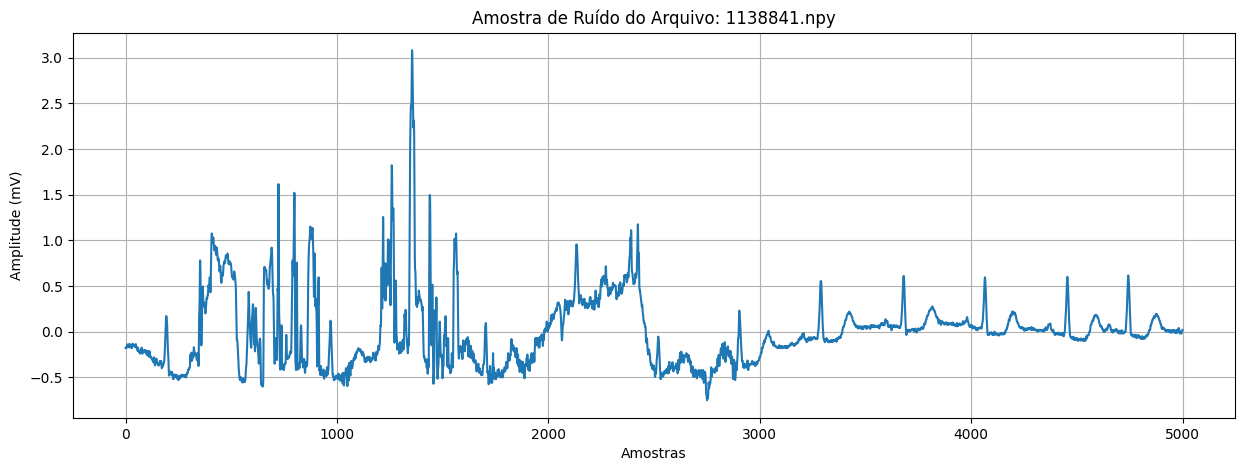

In [21]:
# Caminho para a nova pasta de destino com os arquivos .npy
destination_dir = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), 'data', 'processed', 'physionet-noise-d1-npy')

if os.path.exists(destination_dir) and os.listdir(destination_dir):
    # Listar todos os arquivos .npy criados
    npy_files = [f for f in os.listdir(destination_dir) if f.endswith('.npy')]
    
    if npy_files:
        # Escolher um arquivo .npy aleatório da lista
        random_npy_file = random.choice(npy_files)
        file_path = os.path.join(destination_dir, random_npy_file)
        
        # Carregar o sinal do arquivo .npy
        sample_signal = np.load(file_path)
        
        print(f"Arquivo '{random_npy_file}' carregado com sucesso.")
        print(f"Comprimento do sinal: {len(sample_signal)} pontos.")
        
        # Plotar o sinal
        plt.figure(figsize=(15, 5))
        plt.plot(sample_signal)
        plt.title(f'Amostra de Ruído do Arquivo: {random_npy_file}')
        plt.xlabel('Amostras')
        plt.ylabel('Amplitude (mV)')
        plt.grid(True)
        plt.show()
    else:
        print("Nenhum arquivo .npy encontrado na pasta de destino.")
else:
    print(f"Diretório de destino não encontrado ou está vazio. Execute a célula anterior primeiro.")

### AF Challenge 2017 DATASET e NOISE SET

In [22]:
# --- 1. Definição dos Caminhos ---
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Origem (RAW)
source_training_dir = os.path.join(base_dir, 'data', 'raw', 'basededados', 'training2017')
source_validation_dir = os.path.join(base_dir, 'data', 'raw', 'basededados', 'validation2017')
ref_training_file = os.path.join(source_training_dir, 'REFERENCE.csv')
ref_validation_file = os.path.join(source_validation_dir, 'REFERENCE.csv')
source_noise_mit_bih_dir = os.path.join(base_dir, 'data', 'raw', 'basededados2', 'ruidos', 'mit-bih-noise-stress-test-database-1.0.0')
source_noise_motion_dir = os.path.join(base_dir, 'data', 'raw', 'basededados2', 'ruidos', 'motion-artifact-contaminated-ecg-database-1.0.0')

# Destino (PROCESSED)
dest_training_dir = os.path.join(base_dir, 'data', 'processed', 'basededados', 'training2017')
dest_validation_dir = os.path.join(base_dir, 'data', 'processed', 'basededados', 'validation2017')
dest_ruido_mit_bih_dir = os.path.join(base_dir, 'data', 'processed', 'basededados2', 'ruidos', 'mit-bih-noise-stress-test')
dest_ruido_motion_dir = os.path.join(base_dir, 'data', 'processed', 'basededados2', 'ruidos', 'motion-artifact-contaminated')

# --- 2. Criação dos Diretórios de Destino ---
class_name_map = {'N': 'Normal', 'A': 'AF', 'O': 'Other', '~': 'Ruido'}

print("Verificando e criando a estrutura de diretórios de destino...")
for folder_name in class_name_map.values():
    os.makedirs(os.path.join(dest_training_dir, folder_name), exist_ok=True)
    os.makedirs(os.path.join(dest_validation_dir, folder_name), exist_ok=True)

os.makedirs(dest_ruido_mit_bih_dir, exist_ok=True)
os.makedirs(dest_ruido_motion_dir, exist_ok=True)
print("Estrutura de diretórios pronta.")

Verificando e criando a estrutura de diretórios de destino...
Estrutura de diretórios pronta.


In [24]:
def process_af_challenge_data_to_npy(source_dir, dest_dir, reference_file, class_map):
    print(f"\nProcessando dados de '{os.path.basename(source_dir)}' para .npy...")
    try:
        df = pd.read_csv(reference_file, header=None, names=['RecordName', 'Label'])
    except FileNotFoundError:
        print(f"ERRO: Arquivo de referência não encontrado. Pulando este diretório.")
        return

    processed_count = 0
    for index, row in df.iterrows():
        record_name = row['RecordName']
        label = row['Label']
        
        target_folder_name = class_map.get(label)
        if not target_folder_name:
            print(f"  - Pulando {record_name}: rótulo desconhecido '{label}'.")
            continue

        target_dest_folder = os.path.join(dest_dir, target_folder_name)
        record_path = os.path.join(source_dir, record_name)

        try:
            record = wfdb.rdrecord(record_path)
            signal = record.p_signal.flatten()
            
            if np.isnan(signal).all():
                print(f"  - Pulando {record_name}: sinal inválido (NaN).")
                continue

            output_npy_path = os.path.join(target_dest_folder, f"{record_name}.npy")
            np.save(output_npy_path, signal)
            processed_count += 1
            
        except Exception as e:
            print(f"  - Falha ao processar {record_name}. Erro: {e}")
            
    print(f"Processamento concluído. {processed_count} arquivos .npy salvos.")

def process_noise_data_to_npy(source_dir, dest_dir):
    print(f"\nProcessando ruídos de '{os.path.basename(source_dir)}' para .npy...")
    record_names = [f.split('.')[0] for f in os.listdir(source_dir) if f.endswith('.hea')]
    
    processed_count = 0
    for record_name in record_names:
        record_path = os.path.join(source_dir, record_name)
        try:
            record = wfdb.rdrecord(record_path)
            signal_index = 1 if record.n_sig > 1 else 0
            signal = record.p_signal[:, signal_index].flatten()

            if np.isnan(signal).all():
                print(f"  - Pulando {record_name}: sinal inválido (NaN).")
                continue
                
            output_npy_path = os.path.join(dest_dir, f"{record_name}.npy")
            np.save(output_npy_path, signal)
            processed_count += 1

        except Exception as e:
            print(f"  - Falha ao processar {record_name}. Erro: {e}")
    
    print(f"Processamento concluído. {processed_count} arquivos .npy de ruído salvos.")

In [25]:
# Processar AF Challenge 2017 (Treinamento e Validação)
process_af_challenge_data_to_npy(source_training_dir, dest_training_dir, ref_training_file, class_name_map)
process_af_challenge_data_to_npy(source_validation_dir, dest_validation_dir, ref_validation_file, class_name_map)

# Processar datasets de ruído puro para suas pastas SEPARADAS
process_noise_data_to_npy(source_noise_mit_bih_dir, dest_ruido_mit_bih_dir)
process_noise_data_to_npy(source_noise_motion_dir, dest_ruido_motion_dir)


Processando dados de 'training2017' para .npy...
Processamento concluído. 8528 arquivos .npy salvos.

Processando dados de 'validation2017' para .npy...
Processamento concluído. 300 arquivos .npy salvos.

Processando ruídos de 'mit-bih-noise-stress-test-database-1.0.0' para .npy...
Processamento concluído. 15 arquivos .npy de ruído salvos.

Processando ruídos de 'motion-artifact-contaminated-ecg-database-1.0.0' para .npy...
Processamento concluído. 27 arquivos .npy de ruído salvos.


In [26]:
print("\n--- Contagem Final de Arquivos .npy Processados ---")

# Contar arquivos no diretório de treinamento
print("\n[Diretório: basededados/training2017]")
for label, folder_name in class_name_map.items():
    path = os.path.join(dest_training_dir, folder_name)
    count = len([f for f in os.listdir(path) if f.endswith('.npy')])
    print(f"  - Classe {folder_name}: {count} arquivos")

# Contar arquivos no diretório de validação
print("\n[Diretório: basededados/validation2017]")
for label, folder_name in class_name_map.items():
    path = os.path.join(dest_validation_dir, folder_name)
    count = len([f for f in os.listdir(path) if f.endswith('.npy')])
    print(f"  - Classe {folder_name}: {count} arquivos")

# Contar arquivos nos diretórios de ruído separado
print("\n[Diretório: basededados2/ruidos]")
count_mit = len([f for f in os.listdir(dest_ruido_mit_bih_dir) if f.endswith('.npy')])
print(f"  - Dataset MIT-BIH Noise: {count_mit} arquivos de ruído")

count_motion = len([f for f in os.listdir(dest_ruido_motion_dir) if f.endswith('.npy')])
print(f"  - Dataset Motion Artifact: {count_motion} arquivos de ruído")


--- Contagem Final de Arquivos .npy Processados ---

[Diretório: basededados/training2017]
  - Classe Normal: 5050 arquivos
  - Classe AF: 738 arquivos
  - Classe Other: 2456 arquivos
  - Classe Ruido: 284 arquivos

[Diretório: basededados/validation2017]
  - Classe Normal: 150 arquivos
  - Classe AF: 50 arquivos
  - Classe Other: 70 arquivos
  - Classe Ruido: 30 arquivos

[Diretório: basededados2/ruidos]
  - Dataset MIT-BIH Noise: 15 arquivos de ruído
  - Dataset Motion Artifact: 27 arquivos de ruído


In [12]:
# --- Caminhos para os diretórios processados ---
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Caminhos para o dataset basededados (AF Challenge)
dest_training_dir = os.path.join(base_dir, 'data', 'processed', 'basededados', 'training2017')
dest_validation_dir = os.path.join(base_dir, 'data', 'processed', 'basededados', 'validation2017')

# Caminhos para os datasets de ruído em basededados2
dest_ruido_mit_bih_dir = os.path.join(base_dir, 'data', 'processed', 'basededados2', 'ruidos', 'mit-bih-noise-stress-test')
dest_ruido_motion_dir = os.path.join(base_dir, 'data', 'processed', 'basededados2', 'ruidos', 'motion-artifact-contaminated')

In [27]:
def plot_random_npy_from_folder(folder_path, num_to_plot=2):
    """
    Carrega e plota um número de sinais de ECG aleatórios de uma pasta
    que contém arquivos .npy individuais.
    """
    # Extrai nomes para os títulos dos gráficos
    try:
        folder_name = os.path.basename(os.path.dirname(folder_path))
        class_name = os.path.basename(folder_path)
    except:
        folder_name = "Diretório"
        class_name = os.path.basename(folder_path)

    print(f"--- Plotando {num_to_plot} exemplos de: {folder_name} / {class_name} ---")

    # Verifica se a pasta de destino existe e não está vazia
    if not os.path.exists(folder_path) or not os.listdir(folder_path):
        print("Diretório não encontrado ou está vazio.")
        print("-" * 50)
        return

    all_npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

    if not all_npy_files:
        print("Nenhum arquivo .npy encontrado nesta pasta.")
        print("-" * 50)
        return
        
    if len(all_npy_files) < num_to_plot:
        files_to_plot = all_npy_files
    else:
        files_to_plot = random.sample(all_npy_files, num_to_plot)

    for file_name in files_to_plot:
        try:
            file_path = os.path.join(folder_path, file_name)
            
            signal = np.load(file_path)
            
            fs = 300 
            time_axis = np.arange(len(signal)) / fs
            
            plt.figure(figsize=(15, 4))
            plt.plot(time_axis, signal)
            plt.title(f'Classe: {class_name} - Arquivo: {file_name}')
            plt.xlabel('Tempo (s)')
            plt.ylabel('Amplitude (mV)')
            plt.grid(True)
            plt.show()
            
        except Exception as e:
            print(f"  - Falha ao plotar {file_name}. Erro: {e}")
            
    print("-" * 50)

--- Plotando 2 exemplos de: training2017 / AF ---


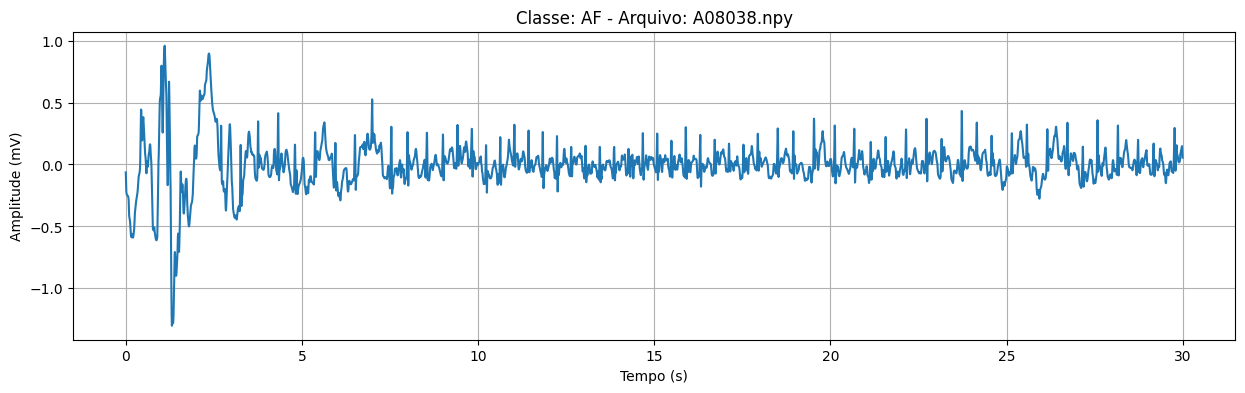

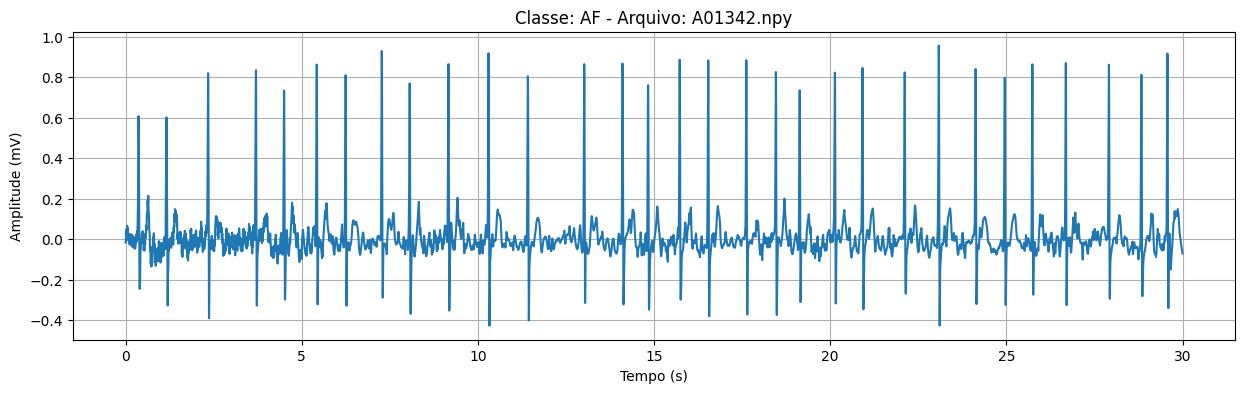

--------------------------------------------------
--- Plotando 2 exemplos de: training2017 / Normal ---


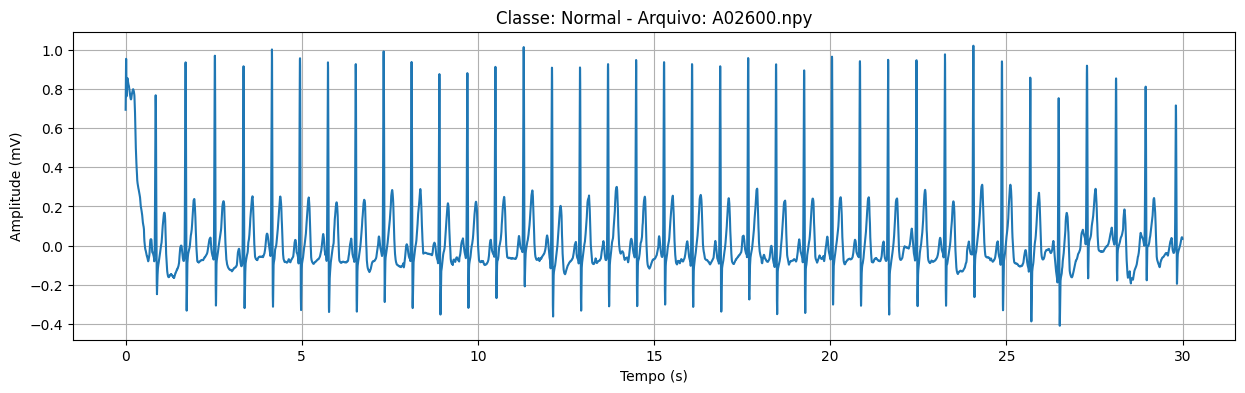

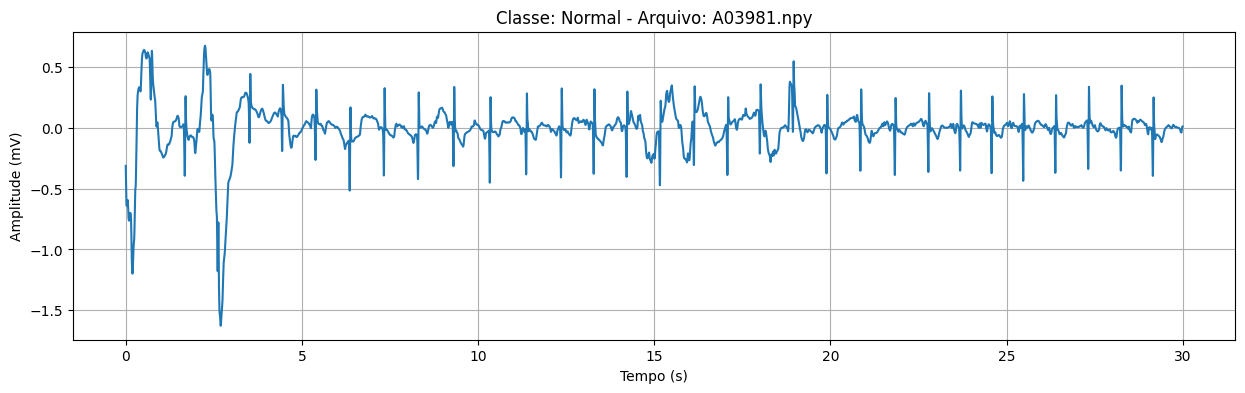

--------------------------------------------------
--- Plotando 2 exemplos de: training2017 / Other ---


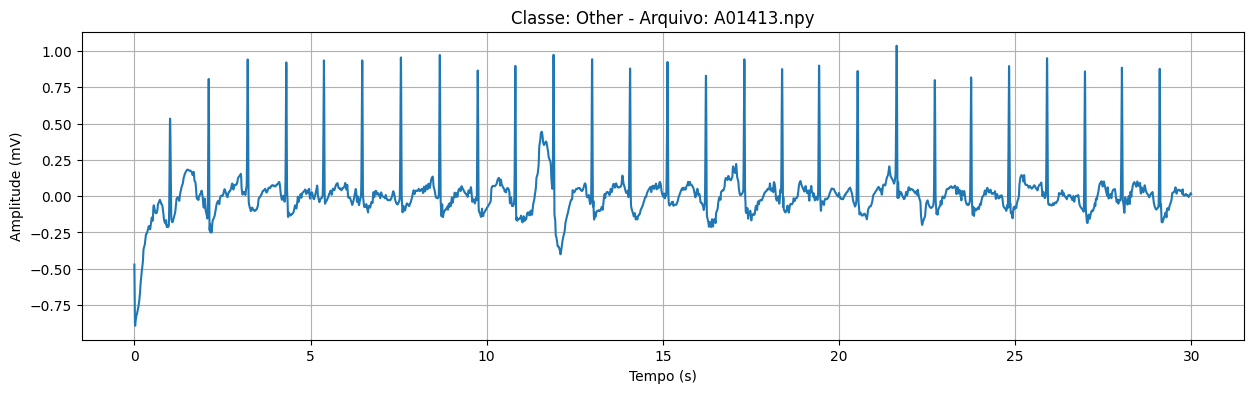

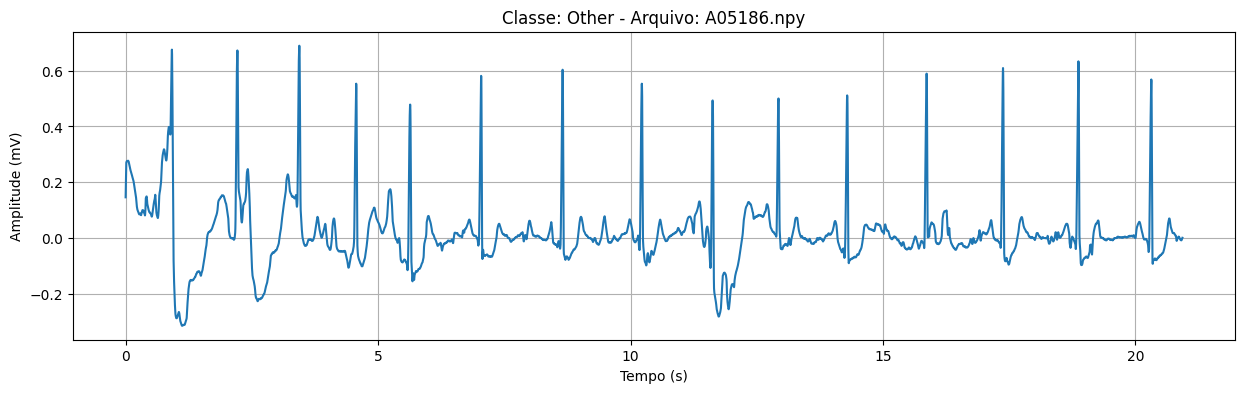

--------------------------------------------------
--- Plotando 2 exemplos de: training2017 / Ruido ---


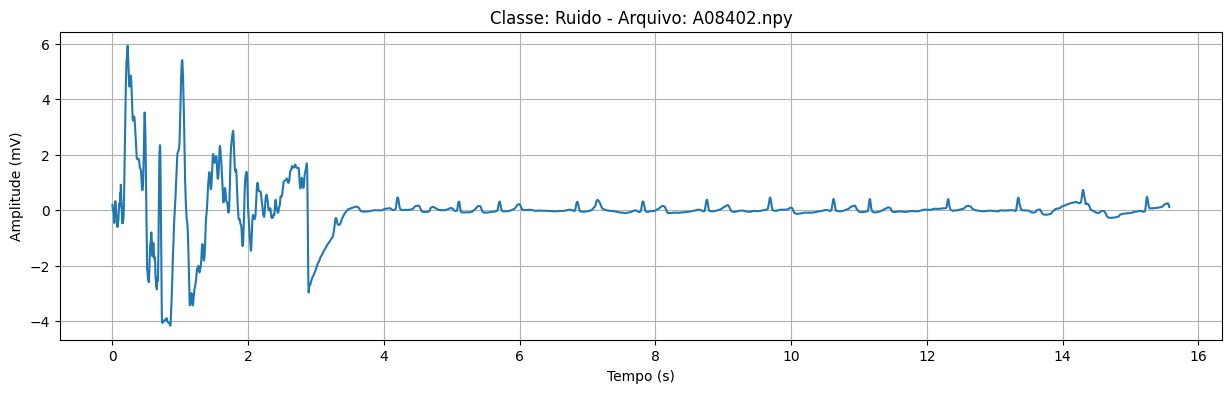

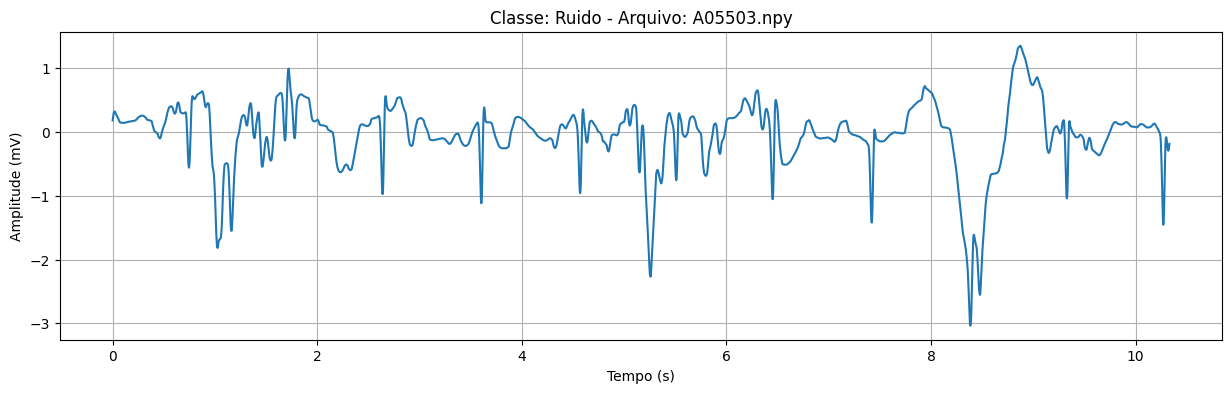

--------------------------------------------------
--- Plotando 2 exemplos de: ruidos / mit-bih-noise-stress-test ---


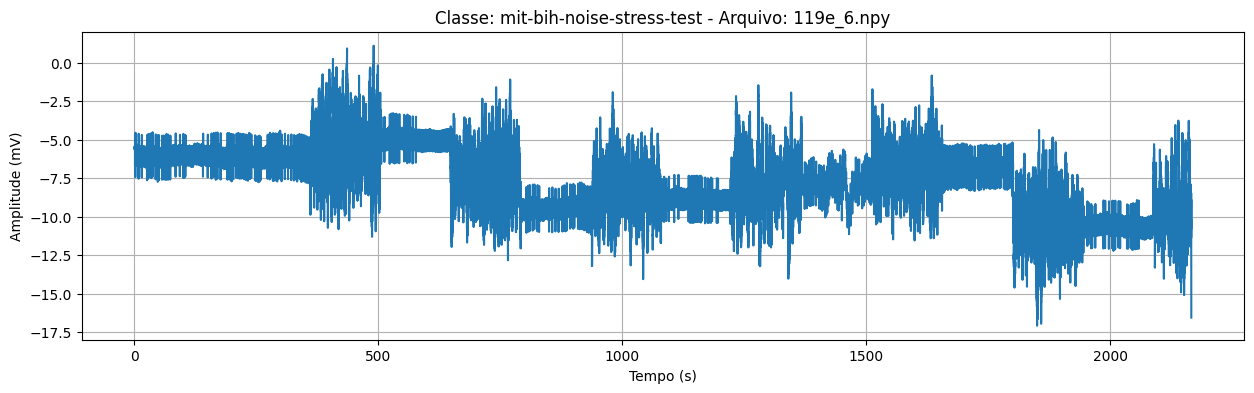

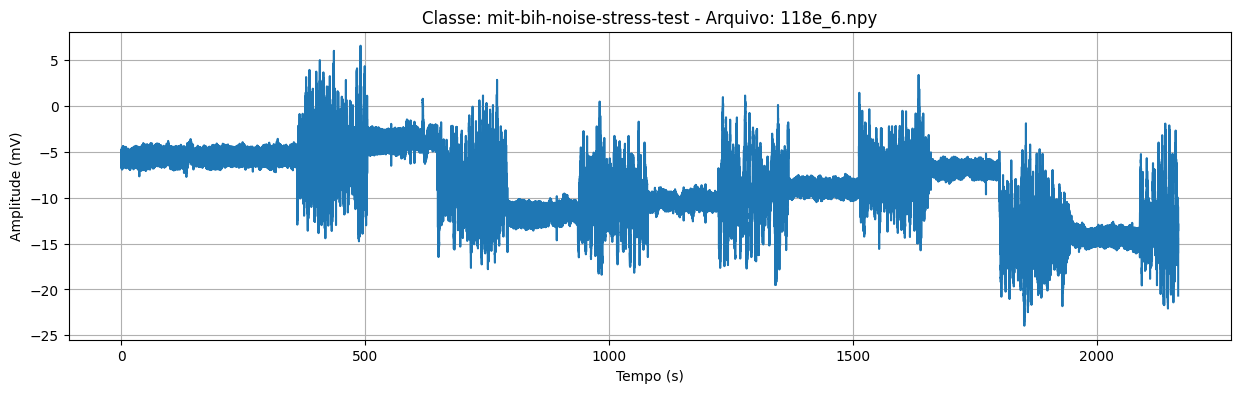

--------------------------------------------------
--- Plotando 2 exemplos de: ruidos / motion-artifact-contaminated ---


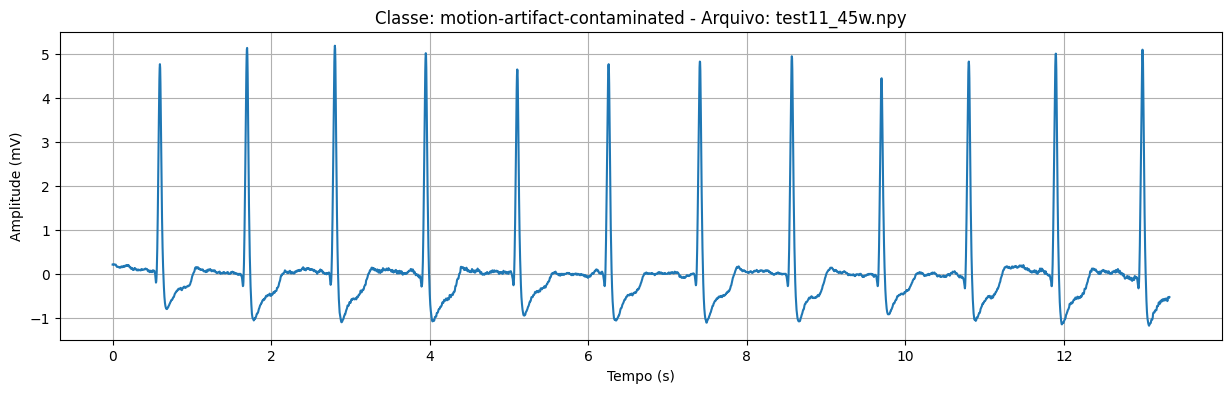

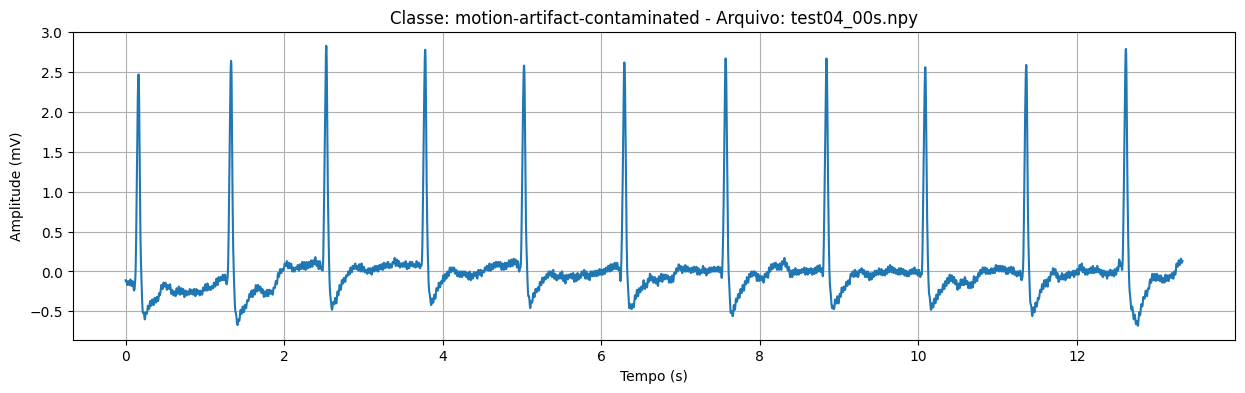

--------------------------------------------------


In [28]:
# --- Caminhos para os diretórios processados ---
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Caminhos para o dataset basededados (AF Challenge)
dest_training_dir = os.path.join(base_dir, 'data', 'processed', 'basededados', 'training2017')

# Caminhos para os datasets de ruído em basededados2
dest_ruido_mit_bih_dir = os.path.join(base_dir, 'data', 'processed', 'basededados2', 'ruidos', 'mit-bih-noise-stress-test')
dest_ruido_motion_dir = os.path.join(base_dir, 'data', 'processed', 'basededados2', 'ruidos', 'motion-artifact-contaminated')


# --- Executar a plotagem para cada classe ---

# Exemplos do conjunto de treinamento
plot_random_npy_from_folder(os.path.join(dest_training_dir, 'AF'))
plot_random_npy_from_folder(os.path.join(dest_training_dir, 'Normal'))
plot_random_npy_from_folder(os.path.join(dest_training_dir, 'Other'))
plot_random_npy_from_folder(os.path.join(dest_training_dir, 'Ruido'))

# Exemplos dos datasets de ruído puro
plot_random_npy_from_folder(dest_ruido_mit_bih_dir)
plot_random_npy_from_folder(dest_ruido_motion_dir)